# Lab 5: In lab exercise
## st121411

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [2]:
# Generate data for class 1

mu_1 = np.array([1.0, 2.0])
sigma_1 = 1
num_sample = 100
cov_mat = np.matrix([[sigma_1,0],[0,sigma_1]])
X1 = np.random.multivariate_normal(mean= mu_1, cov=cov_mat, size = num_sample)

# Generate data for class 2

angle = np.random.uniform(0, 2*np.pi, num_sample)
d =  np.random.normal(np.square(3*sigma_1),np.square(.5*sigma_1),num_sample)
X2 = np.array([X1[:,0] + d*np.cos(angle), X1[:,1] + d*np.sin(angle)]).T

# Combine X1 and X2 into single dataset

X = np.concatenate([X1, X2],axis = 0)
y = np.append(np.zeros(num_sample),np.ones(num_sample))

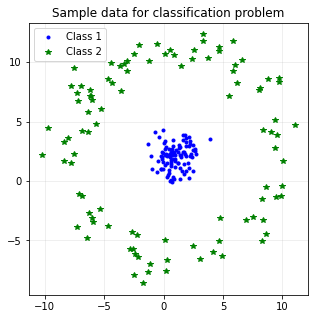

In [3]:
# Plot the data
fig1 = plt.figure(figsize=(5,5))
ax = plt.axes() 
plt.title('Sample data for classification problem')
plt.grid(axis='both', alpha=.25)
plt.plot(X1[:,0],X1[:,1],'b.', label = 'Class 1')
plt.plot(X2[:,0],X2[:,1],'g*', label = 'Class 2')
plt.legend(loc=2)
plt.axis('equal')
plt.show()

In [4]:
# Split data into training and test datasets

idx = np.arange(0,len(X),1)
np.random.shuffle(idx)
idx_train = idx[0:int(.8*len(X))]
idx_test = idx[len(idx_train):len(idx)]

X_train = X[idx_train]
X_test = X[idx_test]
y_train = y[idx_train]
y_test = y[idx_test]

In [5]:
# Normalization of data
def normalization(X):
    """
    Take in numpy array of X values and return normalize X values,
    the mean and standard deviation of each feature
    """
    mean=np.mean(X,axis=0)
    std=np.std(X,axis=0)
    
    X_norm = (X - mean)/std
    return X_norm

mean = np.mean(X,axis=0)
std = np.std(X,axis=0)

XX = (X-mean)/std
X_train_norm = XX[idx_train]
X_test_norm = XX[idx_test]

X_design_train = np.insert(X_train_norm,0,1,axis=1)
X_design_test = np.insert(X_test_norm,0,1,axis=1)

m,n = X_design_train.shape

print(X_train_norm.shape)
print(X_design_train.shape)
print(X_test_norm.shape)
print(X_design_test.shape)

(160, 2)
(160, 3)
(40, 2)
(40, 3)


In [6]:
# define class for logistic regression: batch gradient descent
class Logistic_BGD:
      
    def __init__(self):
        pass
    
    def sigmoid(self,z):   
        return 1 / (1 + np.exp(-z))

    def softmax(self, z):
        z -= np.max(z)
        return np.exp(z) / np.sum(np.exp(z))
    
    def h(self,X, theta):
        return self.sigmoid(X @ theta)
    
    def h2(self, X, theta):
        return self.softmax(np.dot(X,theta))
    
    def gradient(self, X, y, y_pred):
        m = len(y)
        grad = - X.T @ (y - y_pred) / m
        return grad
        
    def costFunc(self, theta, X, y):    
        m = len(y)
        y_pred = self.h(X,theta)
        error = (-y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred))
        cost = 1/m * sum(error)    
        grad = self.gradient(X, y, y_pred)
        return cost, grad
    
    def gradientAscent(self, X, y, theta, alpha, num_iters):
        m = len(y)
        J_history = []
        theta_history = []
        for i in range(num_iters):
            cost, grad = self.costFunc(theta,X,y)
            theta = theta - alpha * grad
            J_history.append(cost)
            theta_history.append(theta)
        J_min_index = np.argmin(J_history)
        print("Minimum at iteration:",J_min_index)
        return theta_history[J_min_index] , J_history

    def predict(self,X, theta):
        labels=[]
        for i in range(0,X.shape[0]):
            y1=self.h(X[i].reshape(1,-1),theta)
            if y1 >=  0.5:
                labels.append(1)
            else:
                labels.append(0)
        
        labels=np.asarray(labels)
        return labels
     
    def getAccuracy(self,X,y,theta):
        y_pred=self.predict(X,theta)
        correct=np.sum(y_pred == y)
        total = y.size
        return (float(correct)/float(total))*100

In [7]:
initial_theta = np.zeros(n)

print(initial_theta)

[0. 0. 0.]


In [8]:
alpha = 0.001
iterations = 50000

BGD_model = Logistic_BGD()

bgd_theta, bgd_cost =  BGD_model.gradientAscent(X_design_train,y_train,initial_theta,alpha,iterations)
print(bgd_theta)

Minimum at iteration: 49999
[-0.03824034 -0.18273578  0.30639   ]


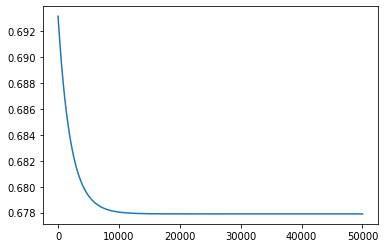

In [9]:
iter_series = np.linspace(1,iterations,iterations)
plt.plot(iter_series,bgd_cost)

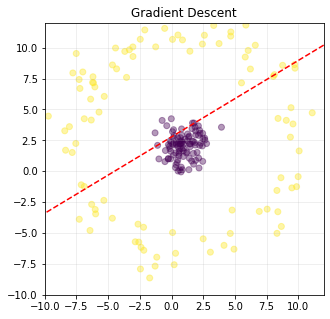

In [10]:
boundary_x = (np.linspace(-12,12,100)-mean[0])/std[0]
#print(boundary_x)
#print(X_train_norm[:,0])
boundary_y = (-bgd_theta[1]*boundary_x - bgd_theta[0])/bgd_theta[2]

boundary_x = boundary_x*std[0]+mean[0]
boundary_y = boundary_y*std[1]+mean[1]

fig1 = plt.figure(figsize=(5,5))
ax = plt.axes() 
plt.title('Gradient Descent')
plt.grid(axis='both', alpha=.25)
plt.scatter(X[:,0],X[:,1],c=y,alpha=0.4)
plt.plot(boundary_x,boundary_y,'r--')
plt.xlim([-10,12])
plt.ylim([-10,12])
plt.show()

In [11]:
print("Accuracy =",BGD_model.getAccuracy(X_design_test,y_test,bgd_theta))

Accuracy = 65.0


Using batch gradient descent, I was able to find the optimized theta in approximately 50000 iterations. Since the dataset is actually not separable with a straight line when represented in cartesian coordinates, the accuracy is extremely low. 

In [12]:
class Logistic_NM: #logistic regression for newton's method
      
    def __init__(self):
        pass
    
    def sigmoid(self,z):   
        return 1 / (1 + np.exp(-z))

    def h(self,X, theta):
        return self.sigmoid(X @ theta)

    def gradient(self, X, y, y_pred):
        m = len(y)
        grad = - X.T @ (y - y_pred) / m
        return grad
        
    def hessian(self, X, y, theta):
        m = len(y)
        y_pred = self.h(X,theta).reshape(-1,1)
        hess_mat = X.T@X*(y_pred.T@(1-y_pred))/m
        return hess_mat
        
    def costFunc(self, theta, X, y):    
        m = len(y)
        y_pred = self.h(X,theta)
        error = (-y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred))
        cost = 1/m * sum(error)    
        grad = self.gradient(X, y, y_pred)
        return cost, grad
    
    def newtonsMethod(self, X, y, theta, num_iters):
        m = len(y)
        J_history = []
        theta_history = []
        for i in range(num_iters):
            cost, grad = self.costFunc(theta,X,y)
            theta = theta - np.linalg.inv(self.hessian(X,y,theta))@grad
            J_history.append(cost)
            theta_history.append(theta)
        J_min_index = np.argmin(J_history)
        print("Minimum at iteration:", J_min_index)
        return theta_history[J_min_index] , J_history

    def predict(self,X, theta):
        labels=[]
        for i in range(0,X.shape[0]):
            y1=self.h(X[i].reshape(1,-1),theta)
            if y1 >=  0.5:
                labels.append(1)
            else:
                labels.append(0)
        
        labels=np.asarray(labels)
        return labels
     
    def getAccuracy(self,X,y,theta):
        y_pred=self.predict(X,theta)
        correct=np.sum(y_pred == y)
        total = y.size
        return (float(correct)/float(total))*100

In [13]:
NM_model = Logistic_NM()

iterations = 1000

nm_theta, nm_cost = NM_model.newtonsMethod(X_design_train, y_train, initial_theta, iterations)
print("theta:",nm_theta)

Minimum at iteration: 999
theta: [-0.03815246 -0.18226777  0.3056101 ]


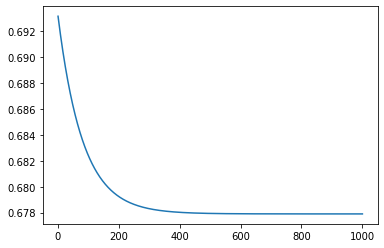

In [14]:
iter_series = np.linspace(1,iterations,iterations)
plt.plot(iter_series,nm_cost)

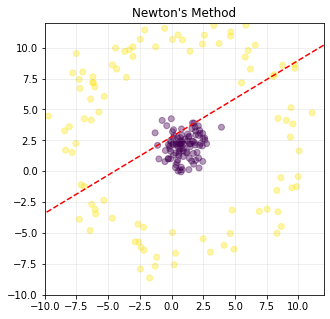

In [15]:
boundary_x = (np.linspace(-12,12,100)-mean[0])/std[0]
#print(boundary_x)
#print(X_train_norm[:,0])
boundary_y = (-nm_theta[1]*boundary_x - nm_theta[0])/nm_theta[2]

boundary_x = boundary_x*std[0]+mean[0]
boundary_y = boundary_y*std[1]+mean[1]

fig1 = plt.figure(figsize=(5,5))
ax = plt.axes() 
plt.title("Newton's Method")
plt.grid(axis='both', alpha=.25)
plt.scatter(X[:,0],X[:,1],c=y,alpha=0.4)
plt.plot(boundary_x,boundary_y,'r--')
plt.xlim([-10,12])
plt.ylim([-10,12])
plt.show()

In [16]:
print("Accuracy =",NM_model.getAccuracy(X_design_test,y_test,bgd_theta))

Accuracy = 65.0


By using newton's method, I was able to reduce the number of iterations down to approximately 1000 iterations. This is 50 times smaller than batch gradient descent thus proving that newton's method is able to converge much faster than batch gradient descent.

In [17]:
Xr_train = np.sqrt(np.sum(X_train**2,axis=1))
Xr_test = np.sqrt(np.sum(X_test**2,axis=1))

Xtheta_train = np.arctan2(X_train[:,1],X_train[:,0])
Xtheta_test = np.arctan2(X_test[:,1],X_test[:,0])

X_polar_train = np.concatenate((np.ones((Xr_train.size,1)),Xtheta_train.reshape(-1,1),Xr_train.reshape(-1,1)),axis=1)
X_polar_test = np.concatenate((np.ones((Xr_test.size,1)),Xtheta_test.reshape(-1,1),Xr_test.reshape(-1,1)),axis=1)
X_polar = np.concatenate((X_polar_train,X_polar_test),axis=0)


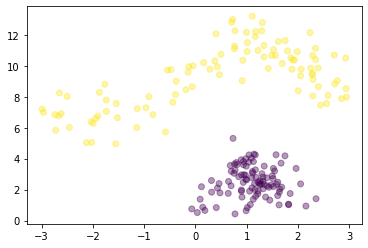

In [18]:
plt.scatter(X_polar[:,1],X_polar[:,2],c=np.concatenate((y_train,y_test),axis=0),alpha=0.4)

In [19]:
iterations = 5000

polar_theta, polar_cost = NM_model.newtonsMethod(X_polar_train, y_train, initial_theta, iterations)
print("theta:",polar_theta)

Minimum at iteration: 4999
theta: [-17.45946639  -2.10604678   3.39541408]


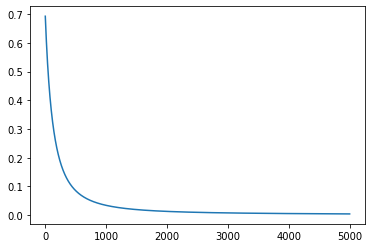

In [20]:
iter_series = np.linspace(1,iterations,iterations)
plt.plot(iter_series,polar_cost)

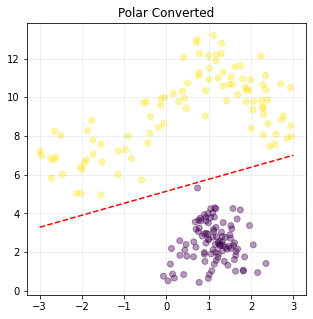

In [21]:
boundary_x = np.linspace(-3,3,100)
boundary_y = (-polar_theta[1]*boundary_x - polar_theta[0])/polar_theta[2]

fig1 = plt.figure(figsize=(5,5))
ax = plt.axes() 
plt.title("Polar Converted")
plt.grid(axis='both', alpha=.25)
plt.scatter(X_polar[:,1],X_polar[:,2],c=np.concatenate((y_train,y_test),axis=0),alpha=0.4)
plt.plot(boundary_x,boundary_y,'r--')
# plt.xlim([-10,12])
# plt.ylim([-10,12])
plt.show()

In [22]:
print("Accuracy =",NM_model.getAccuracy(X_polar_test,y_test,polar_theta))

Accuracy = 100.0


By converting the datapoint's representation into polar coordinates, I was able to get a much higher accuracy. This comes to show how important the representation of the data is. Interestingly, the polar transformed dataset wasn't further normalized after the conversion but it was still able to properly converge and find the optimal decision boundary. 